## Loading Data

In [1]:
pip install kagglehub

Note: you may need to restart the kernel to use updated packages.


In [2]:
import kagglehub
from sklearn.preprocessing import MinMaxScaler
# Download latest version
path = kagglehub.dataset_download("nelgiriyewithana/top-spotify-songs-2023")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Rithi\.cache\kagglehub\datasets\nelgiriyewithana\top-spotify-songs-2023\versions\1


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [4]:
import os
df = pd.read_csv(os.path.join(path, "spotify-2023.csv"), encoding='latin-1')




df.head()

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,...,125,B,Major,80,89,83,31,0,8,4
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,...,92,C#,Major,71,61,74,7,0,10,4
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,...,138,F,Major,51,32,53,17,0,31,6
3,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817,116,...,170,A,Major,55,58,72,11,0,11,15
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322,84,...,144,A,Minor,65,23,80,14,63,11,6


## Data Preprocessing

In [5]:
# Total missing values
print("Missing values per column:\n", df.isnull().sum())

# Percentage of missing data
nan_percent = df.isnull().mean() * 100
print("\nPercentage of missing values:\n", nan_percent)


Missing values per column:
 track_name               0
artist(s)_name           0
artist_count             0
released_year            0
released_month           0
released_day             0
in_spotify_playlists     0
in_spotify_charts        0
streams                  0
in_apple_playlists       0
in_apple_charts          0
in_deezer_playlists      0
in_deezer_charts         0
in_shazam_charts        50
bpm                      0
key                     95
mode                     0
danceability_%           0
valence_%                0
energy_%                 0
acousticness_%           0
instrumentalness_%       0
liveness_%               0
speechiness_%            0
dtype: int64

Percentage of missing values:
 track_name              0.00000
artist(s)_name          0.00000
artist_count            0.00000
released_year           0.00000
released_month          0.00000
released_day            0.00000
in_spotify_playlists    0.00000
in_spotify_charts       0.00000
streams                

In [6]:
print(df.dtypes)

track_name              object
artist(s)_name          object
artist_count             int64
released_year            int64
released_month           int64
released_day             int64
in_spotify_playlists     int64
in_spotify_charts        int64
streams                 object
in_apple_playlists       int64
in_apple_charts          int64
in_deezer_playlists     object
in_deezer_charts         int64
in_shazam_charts        object
bpm                      int64
key                     object
mode                    object
danceability_%           int64
valence_%                int64
energy_%                 int64
acousticness_%           int64
instrumentalness_%       int64
liveness_%               int64
speechiness_%            int64
dtype: object


In [7]:
#dropping columns not needed for analysis based on project needs a nan percentage
df.drop('artist_count', axis=1, inplace=True)
df.drop('in_shazam_charts', axis=1, inplace=True)
df.drop('key',axis=1,inplace=True)

In [8]:
#converting string numbers to numberic
df['streams'] = df['streams'].str.replace(',', '')
df['streams'] = pd.to_numeric(df['streams'], errors='coerce')
df['in_deezer_playlists'] = df['in_deezer_playlists'].str.replace(',', '').astype(float)


In [9]:
# Look at unique values of mode to confirm major and minor are only values before converting into numeric
print("\nUnique values in mode:")
print(df['mode'].unique())



Unique values in mode:
['Major' 'Minor']


In [10]:
df['mode'] = df['mode'].map({'Major': 1, 'Minor': 0})

In [11]:
#deal with dates: identitfy seasons, drop days since unneccesary
def get_season(month): #cooler months= 1,2; warmer= 3,4
    if month in [12, 1, 2]:
        return 2 #winter
    elif month in [3, 4, 5]:
        return 3 #spring
    elif month in [6, 7, 8]:
        return 4 #summer
    elif month in [9, 10, 11]:
        return 1 #fall
    
df['season'] = df['released_month'].apply(get_season)
df.drop('released_day', axis=1, inplace= True)


In [12]:
#check new columns 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   track_name            953 non-null    object 
 1   artist(s)_name        953 non-null    object 
 2   released_year         953 non-null    int64  
 3   released_month        953 non-null    int64  
 4   in_spotify_playlists  953 non-null    int64  
 5   in_spotify_charts     953 non-null    int64  
 6   streams               952 non-null    float64
 7   in_apple_playlists    953 non-null    int64  
 8   in_apple_charts       953 non-null    int64  
 9   in_deezer_playlists   953 non-null    float64
 10  in_deezer_charts      953 non-null    int64  
 11  bpm                   953 non-null    int64  
 12  mode                  953 non-null    int64  
 13  danceability_%        953 non-null    int64  
 14  valence_%             953 non-null    int64  
 15  energy_%              9

### Outlier handling

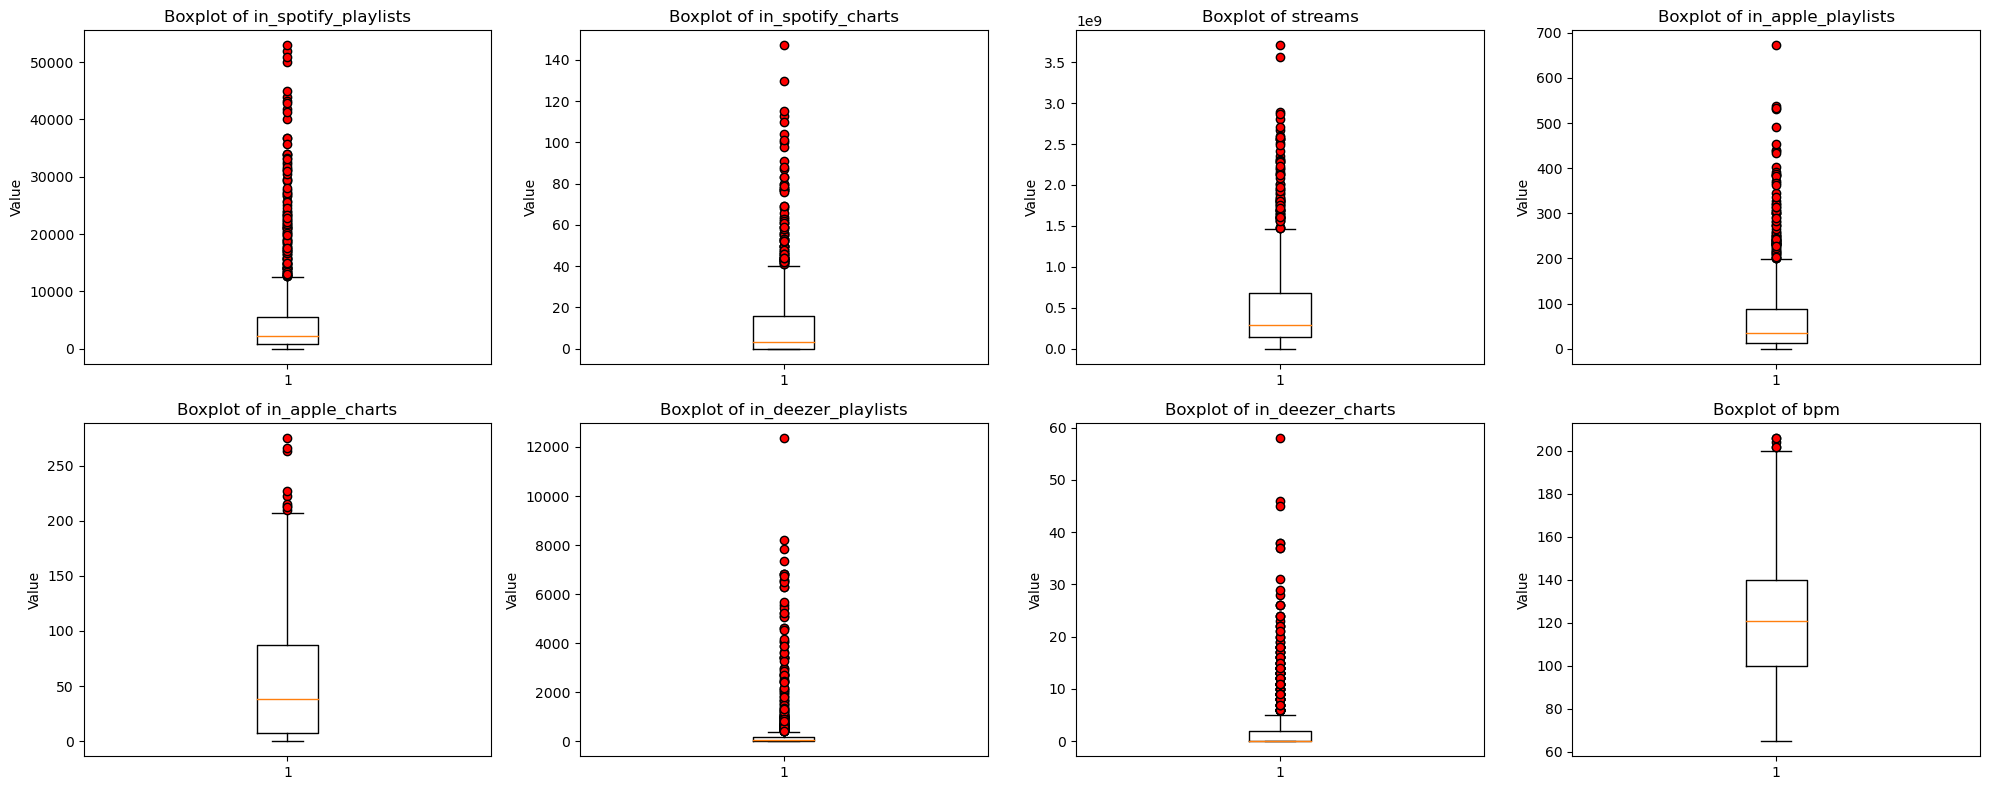

In [13]:
#visualize potential outliers
columns_to_plot = ['in_spotify_playlists',
    'in_spotify_charts',
    'streams',
    'in_apple_playlists',
    'in_apple_charts',
    'in_deezer_playlists',
    'in_deezer_charts', 'bpm']

num_plots = len(columns_to_plot)
cols = 4 
rows = 2

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()

outliermark = dict(marker='o', markerfacecolor='red', markersize=6, linestyle='none')

for i, col in enumerate(columns_to_plot):
    axes[i].boxplot(df[col].dropna(), flierprops=outliermark)
    axes[i].set_title(f'Boxplot of {col}')
    axes[i].set_ylabel('Value')


for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

The dataset is already filtered to only include hit songs, it makes sense that the data is right-skewed (big artists, viral moments). The “outliers” aren’t errors — they’re actually the whole point of the data. We’re not working with the average song, so typical outlier logic doesn’t apply.

In [14]:
# apply log function to deal with upwards skew: Compress extreme values,
cols_to_log = ['in_spotify_playlists', 'in_spotify_charts', 'streams',
               'in_apple_playlists', 'in_apple_charts',
               'in_deezer_playlists', 'in_deezer_charts']

for col in cols_to_log:
    df[col] = np.log1p(df[col])

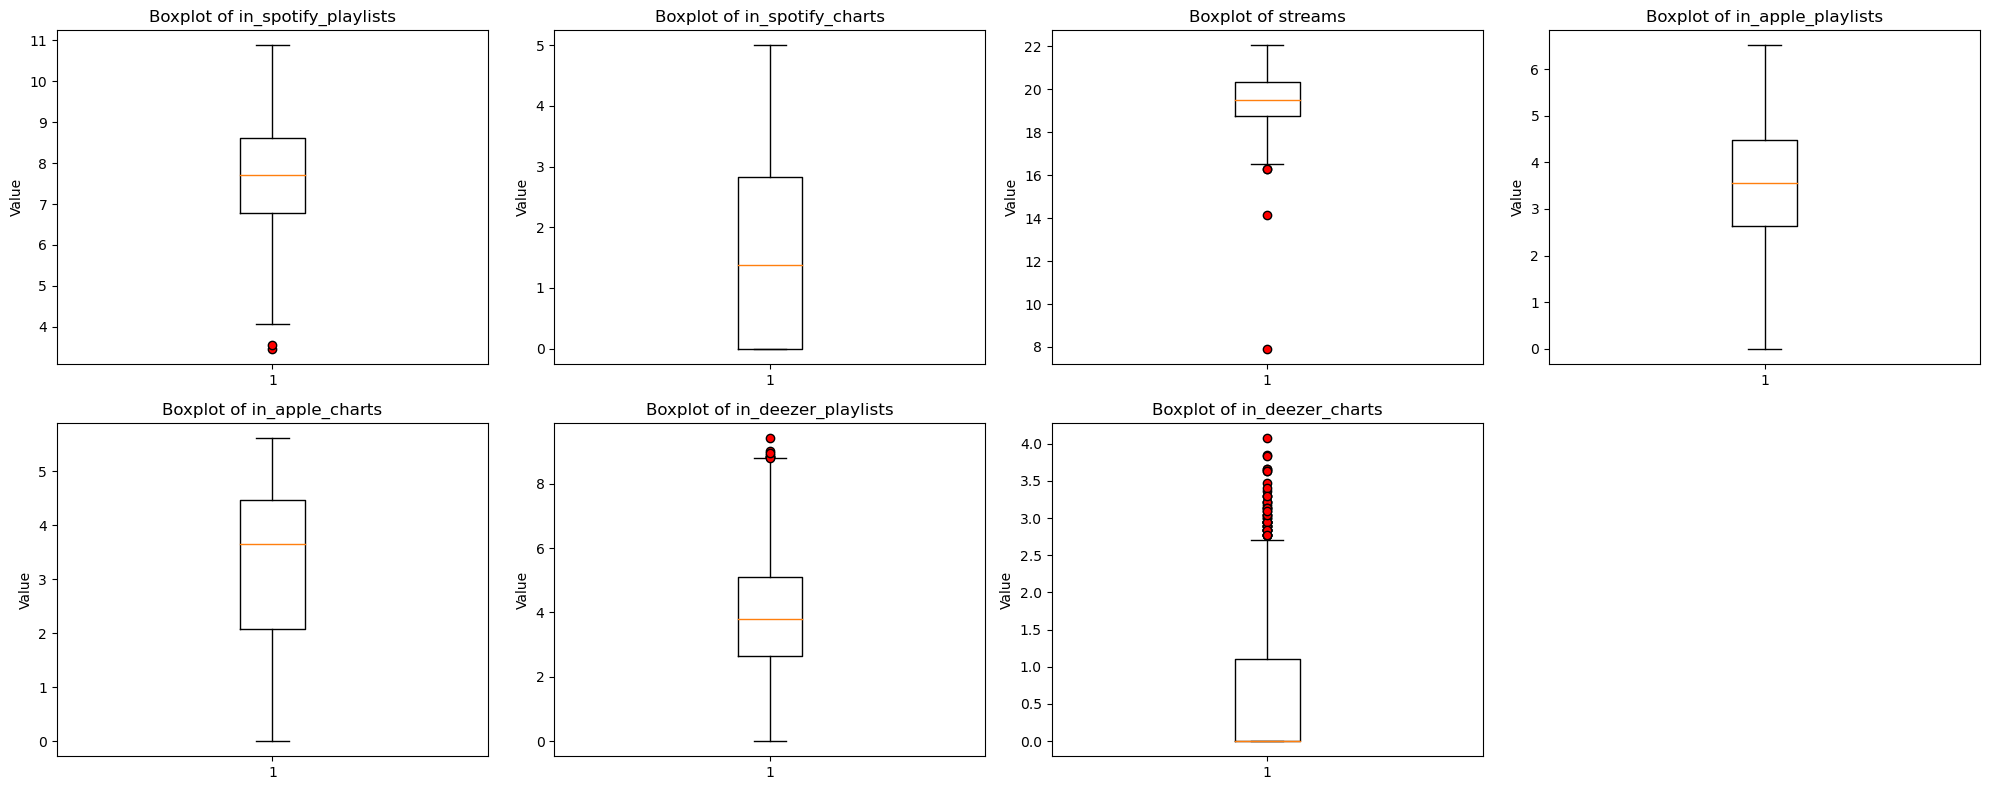

,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,in_apple_charts,in_deezer_playlists,in_deezer_charts
count,953.000000,953.000000,952.000000,953.000000,953.000000,953.000000,953.000000
mean,7.717898,1.510467,19.506648,3.499060,3.151817,3.999342,0.656317
std,1.329587,1.501203,1.146289,1.332688,1.606014,1.911520,0.963816
min,3.465736,0.000000,7.924072,0.000000,0.000000,0.000000,0.000000
25%,6.775366,0.000000,18.768772,2.639057,2.079442,2.639057,0.000000
50%,7.707512,1.386294,19.487220,3.555348,3.663562,3.806662,0.000000
75%,8.620291,2.833213,20.328546,4.488636,4.477337,5.105945,1.098612
max,10.876140,4.997212,22.032651,6.511745,5.620401,9.422868,4.077537


In [15]:
#visualize new log transformed data
#visualize potential outliers
columns_to_plot = ['in_spotify_playlists',
    'in_spotify_charts',
    'streams',
    'in_apple_playlists',
    'in_apple_charts',
    'in_deezer_playlists',
    'in_deezer_charts']

num_plots = len(columns_to_plot)
cols = 4 
rows = 2

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()

outliermark = dict(marker='o', markerfacecolor='red', markersize=6, linestyle='none')

for i, col in enumerate(columns_to_plot):
    axes[i].boxplot(df[col].dropna(), flierprops=outliermark)
    axes[i].set_title(f'Boxplot of {col}')
    axes[i].set_ylabel('Value')


for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

df[cols_to_log].describe()

In [16]:
# drop 'in_deezer_charts' due to significant outliers even after log transformation
df.drop('in_deezer_charts', axis=1, inplace=True)

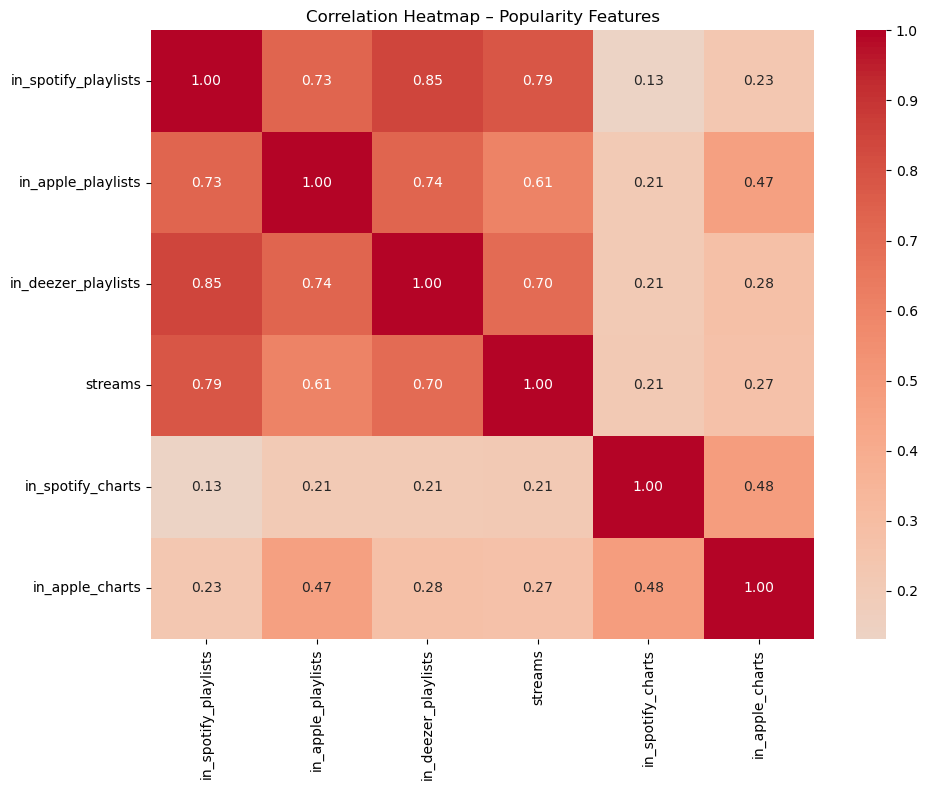

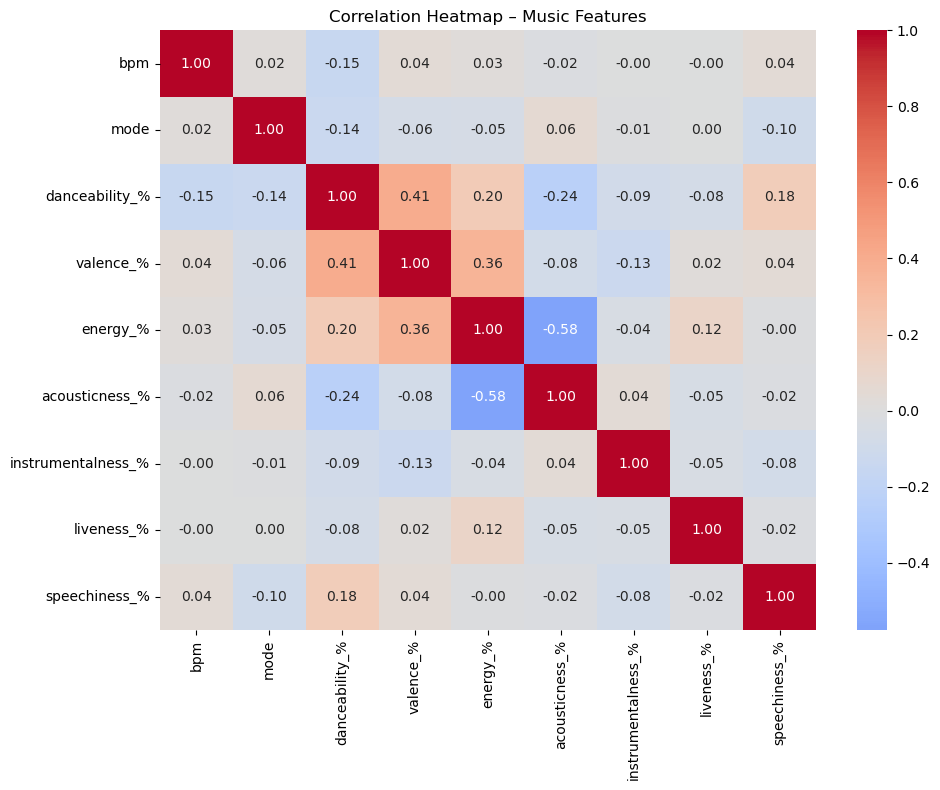

In [17]:
# heatmaps to show correlations
music_features = df[['bpm', 'mode', 'danceability_%', 'valence_%', 
                     'energy_%', 'acousticness_%', 'instrumentalness_%', 
                     'liveness_%', 'speechiness_%']]

popularity = df[['in_spotify_playlists','in_apple_playlists','in_deezer_playlists', 'streams', 
                'in_spotify_charts', 'in_apple_charts']]


# Correlation matrices
corr1 = popularity.corr()
corr2 = music_features.corr()

# First heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr1, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Correlation Heatmap – Popularity Features")
plt.tight_layout()
plt.show()

# Second heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr2, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Correlation Heatmap – Music Features")
plt.tight_layout()
plt.show()

Popularity features map: High correlation shown with: 'in_spotify_playlists','in_apple_playlists','in_deezer_playlists', 'streams'<br>
Music features map: features have low correlation

In [18]:
# Combine Spotify, Apple, and Deezer playlist counts into one total feature
df['playlists_and_streams_total'] = (
    df['in_spotify_playlists'] + 
    df['in_apple_playlists'] + 
    df['in_deezer_playlists']+
    df['streams']
)

df.drop(columns=[
    'in_spotify_playlists', 
    'in_apple_playlists', 
    'in_deezer_playlists', 'streams'
], inplace=True)

print("Number of columns after merge:", df.shape[1])

Number of columns after merge: 17


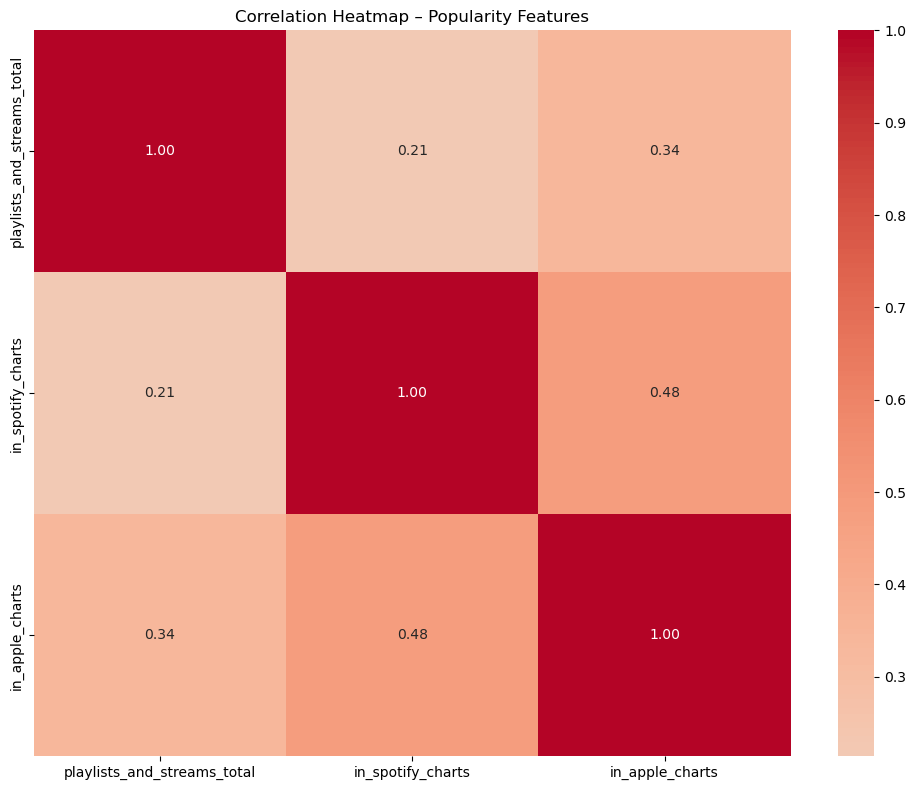

In [22]:

popularity = df[['playlists_and_streams_total', 'in_spotify_charts', 'in_apple_charts']]

corr1 = popularity.corr()

# First heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr1, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Correlation Heatmap – Popularity Features")
plt.tight_layout()
plt.show()



In [23]:
# Define logcol using existing columns
pop = [
    'playlists_and_streams_total',          
    'in_spotify_charts',
    'in_apple_charts'
]

# Function to count outliers using IQR method
def count_outliers_iqr(df, columns):
    outlier_counts = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        count = ((df[col] < lower) | (df[col] > upper)).sum()
        outlier_counts[col] = count
    return outlier_counts

# Print outlier counts
print(count_outliers_iqr(df, pop))
print(count_outliers_iqr(df,music_features))


{'playlists_and_streams_total': 0, 'in_spotify_charts': 0, 'in_apple_charts': 0}
{'bpm': 5, 'mode': 0, 'danceability_%': 3, 'valence_%': 0, 'energy_%': 4, 'acousticness_%': 0, 'instrumentalness_%': 87, 'liveness_%': 44, 'speechiness_%': 136}


In [24]:
outlier_counts = {
    'instrumentalness_%': 87,
    'liveness_%': 44,
    'speechiness_%': 136
}

total_rows = len(df)
outlier_percentages = {feature: round((count / total_rows) * 100, 2)
                       for feature, count in outlier_counts.items()}
for feature, pct in outlier_percentages.items():
    print(f"{feature}: {outlier_counts[feature]} outliers ({pct}%)")


instrumentalness_%: 87 outliers (9.13%)
liveness_%: 44 outliers (4.62%)
speechiness_%: 136 outliers (14.27%)


After joining a dropping columns, resulting heatmap shows features with low correlation values

## Descriptive Charts

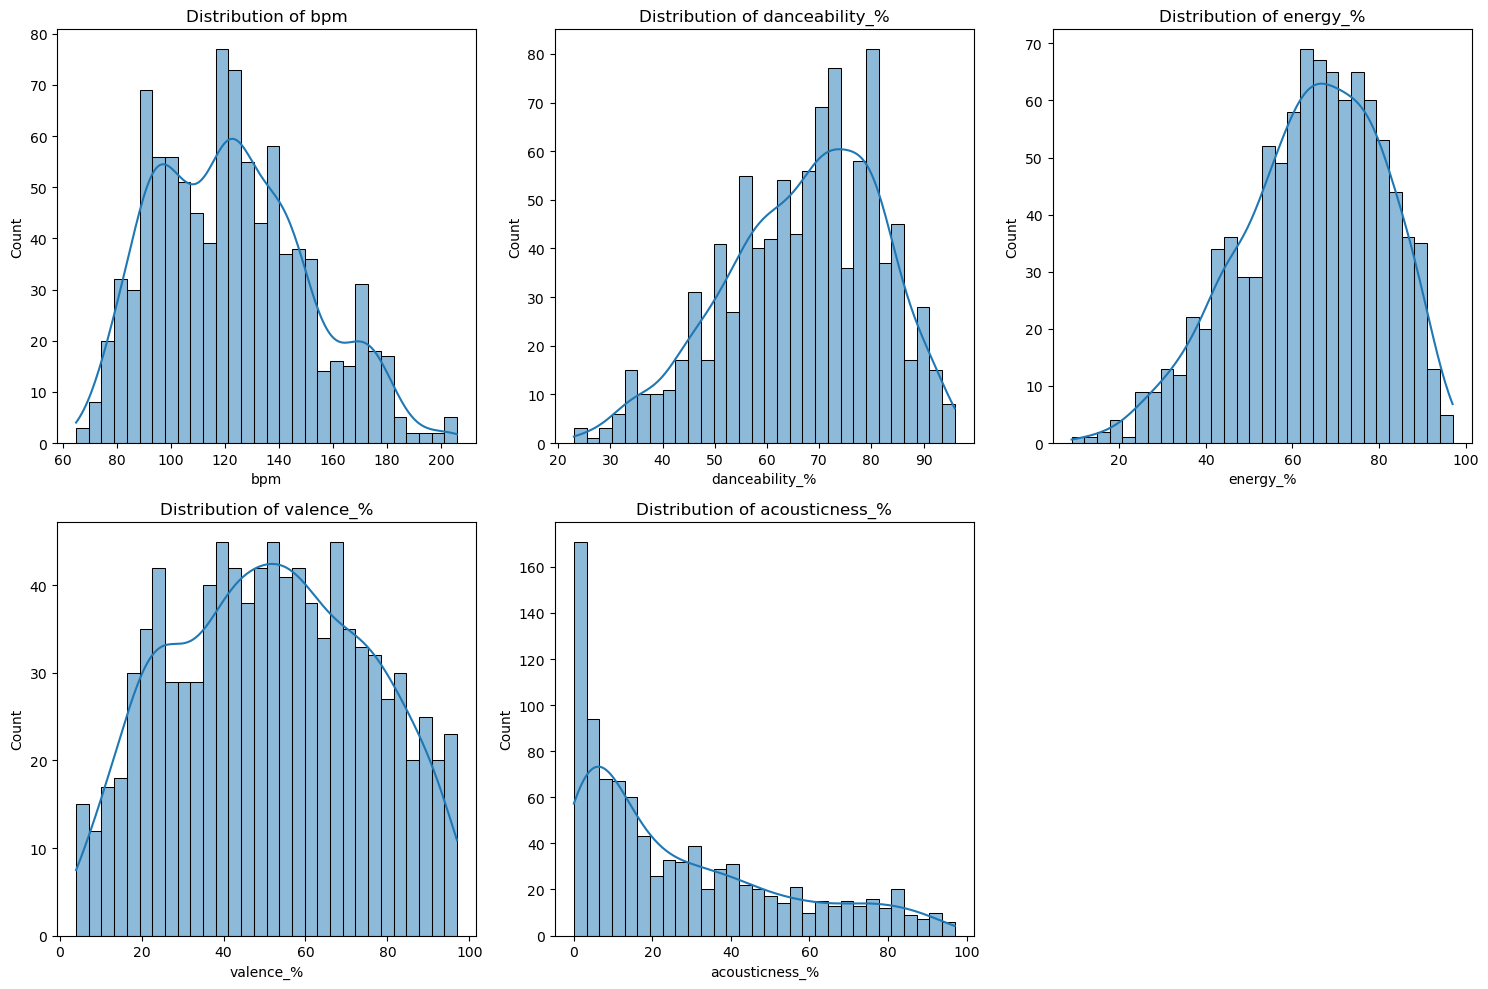

In [25]:
features_to_plot = ['bpm', 'danceability_%', 'energy_%', 'valence_%', 'acousticness_%']


plt.figure(figsize=(15, 10))
for i, col in enumerate(features_to_plot, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()


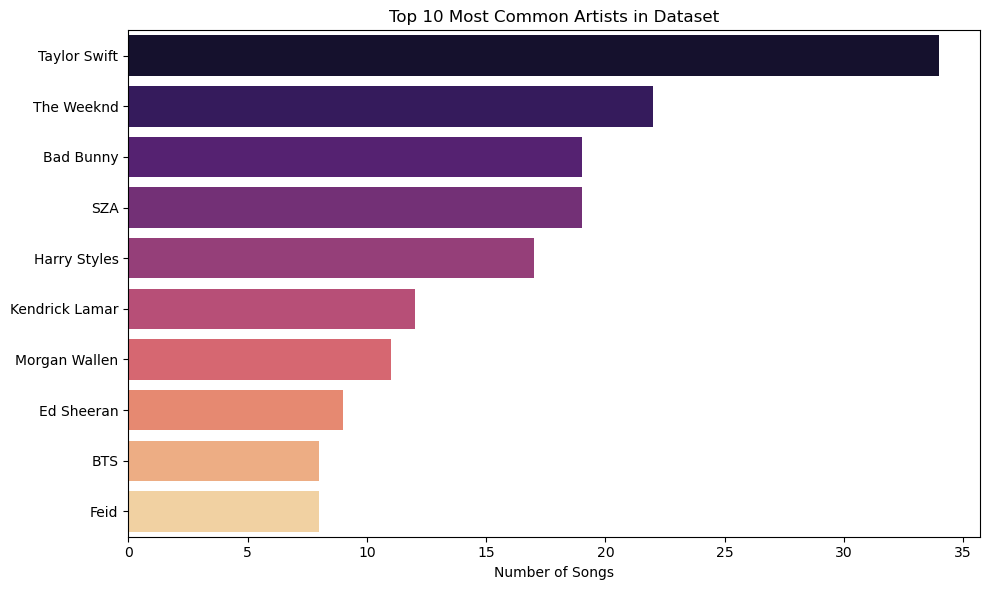

In [26]:
top_artists = df['artist(s)_name'].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_artists.values, y=top_artists.index, palette='magma')
plt.title('Top 10 Most Common Artists in Dataset')
plt.xlabel('Number of Songs')
plt.tight_layout()
plt.show()


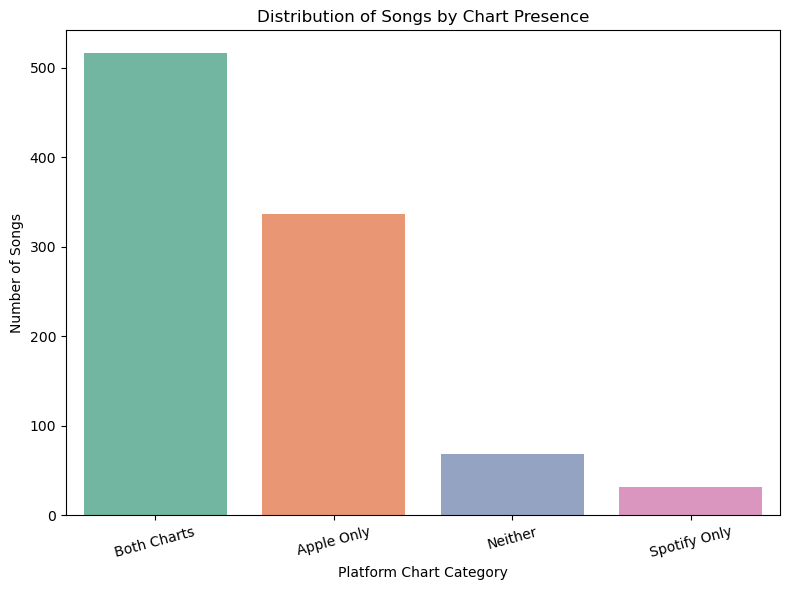

In [27]:
def chart_category(row):
    if row['in_spotify_charts'] and row['in_apple_charts']:
        return 'Both Charts'
    elif row['in_spotify_charts']:
        return 'Spotify Only'
    elif row['in_apple_charts']:
        return 'Apple Only'
    else:
        return 'Neither'

df['chart_presence'] = df.apply(chart_category, axis=1)

# Count songs in each category
chart_counts = df['chart_presence'].value_counts().reset_index()
chart_counts.columns = ['Chart Presence', 'Number of Songs']

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(data=chart_counts, x='Chart Presence', y='Number of Songs', palette='Set2')
plt.title('Distribution of Songs by Chart Presence')
plt.xlabel('Platform Chart Category')
plt.ylabel('Number of Songs')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

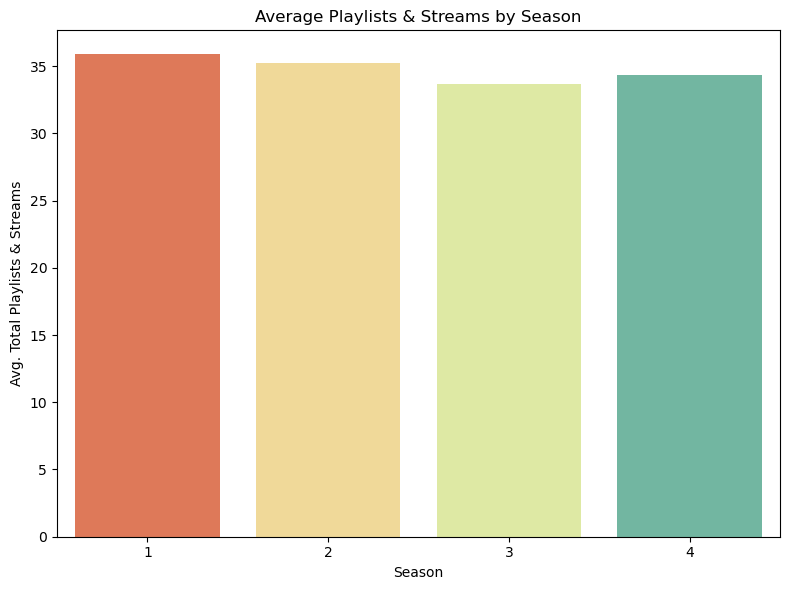

In [28]:
season_streams = df.groupby('season')['playlists_and_streams_total'].mean().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(data=season_streams, x='season', y='playlists_and_streams_total', palette='Spectral')
plt.title('Average Playlists & Streams by Season')
plt.xlabel('Season')
plt.ylabel('Avg. Total Playlists & Streams')
plt.tight_layout()
plt.show()

## Clustering Algorithms to Define Genres

In [29]:
numeric_cols = [
    'bpm', 'mode', 'danceability_%', 'valence_%', 'energy_%',
    'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%','season'
]


pca = PCA(n_components=2)
pca_components = pca.fit_transform(df[numeric_cols])


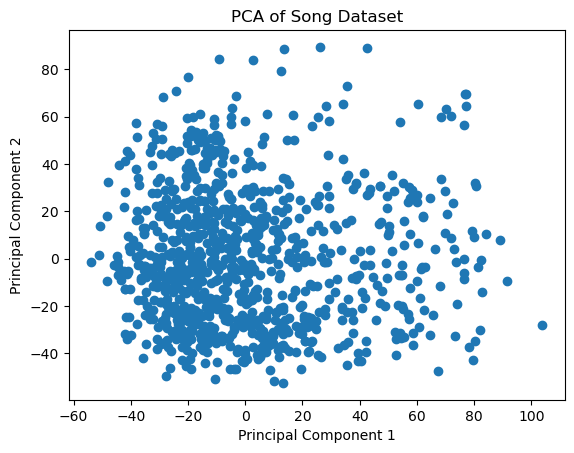

In [30]:
plt.scatter(pca_components[:, 0], pca_components[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Song Dataset')
plt.show()


In [31]:
features = ['danceability_%', 'valence_%', 'energy_%', 'mode'] # "moody"/genre defining features
X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### K means

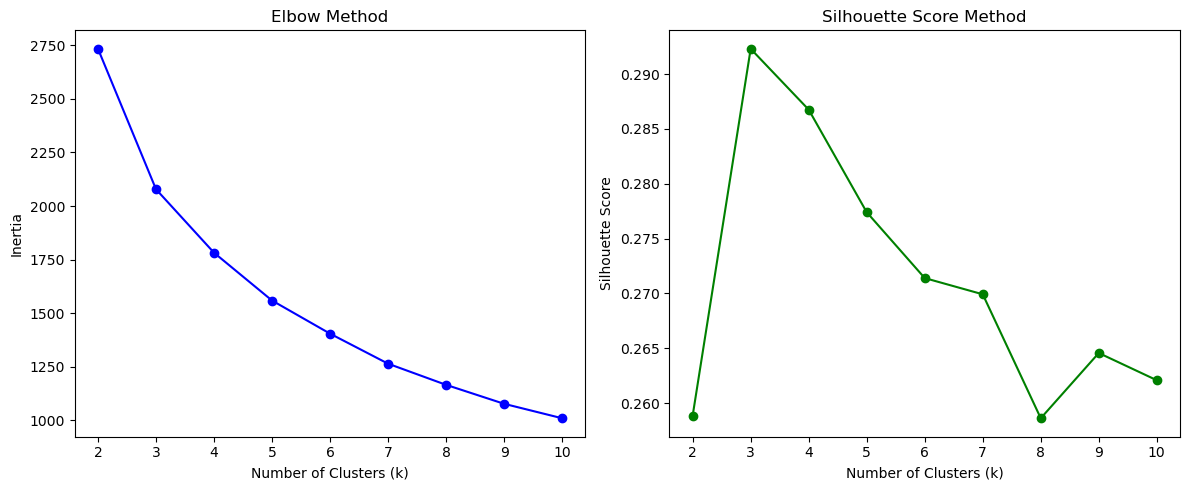

In [32]:
inertia = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot elbow + silhouette
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, 'go-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method')

plt.tight_layout()
plt.show()


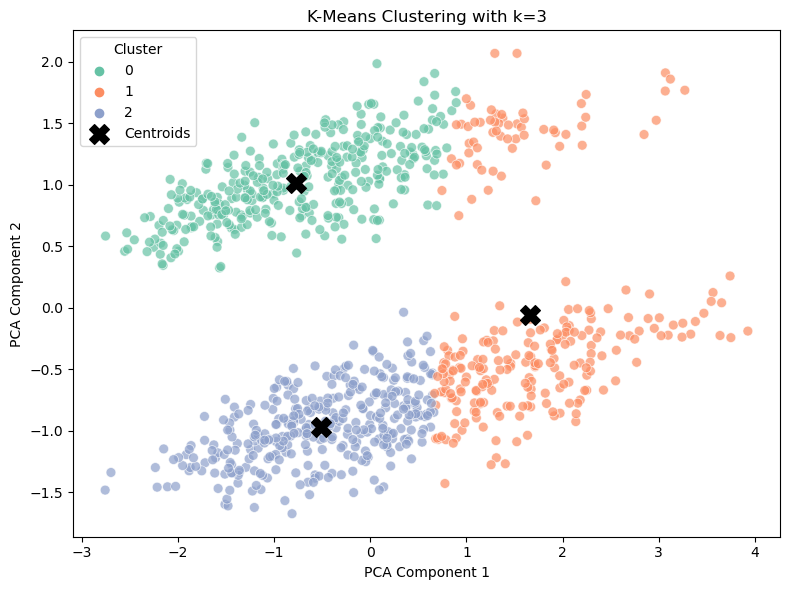

In [33]:
k_final = 3  

kmeans = KMeans(n_clusters=k_final, random_state=42, n_init=10)
df['mood_cluster'] = kmeans.fit_predict(X_scaled)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

centroids_pca = pca.transform(kmeans.cluster_centers_)
plt.figure(figsize=(8, 6))


sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['mood_cluster'], palette='Set2', s=50, alpha=0.7)


plt.scatter(
    centroids_pca[:, 0],
    centroids_pca[:, 1],
    color='black',
    marker='X',
    s=200,
    label='Centroids'
)

plt.title(f'K-Means Clustering with k={k_final}')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

Clusters do not look well defined and the centeroid is reaching an empty data point area to make up for the gap

In [49]:
feature_columns = ['bpm', 'danceability_%', 'valence_%', 'energy_%', 
                   'acousticness_%', 'instrumentalness_%', 
                   'speechiness_%', 'liveness_%', 'mode']


kmeans_means = df.groupby('mood_cluster')[feature_columns].mean().round(2)
kmeans_means


,bpm,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,speechiness_%,liveness_%,mode
mood_cluster,,,,,,,,,
0,122.25,72.83,58.48,67.94,22.90,1.20,11.68,18.20,0.00
1,123.79,52.63,27.75,51.02,40.88,2.98,8.72,17.71,0.77
2,121.87,72.16,62.60,70.82,20.58,0.88,9.68,18.61,1.00


### Hierarchal clustering

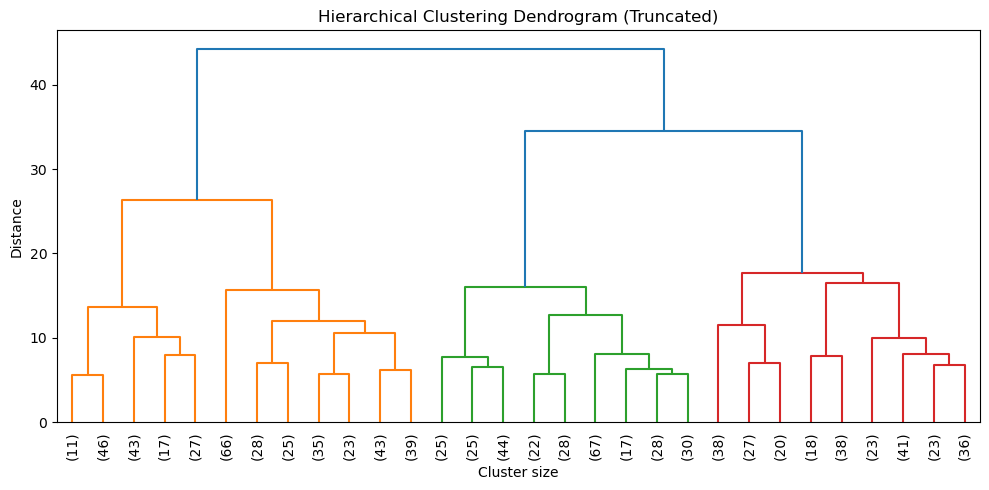

In [35]:


# Create linkage matrix
linked = linkage(X_scaled, method='ward')

# Plot
plt.figure(figsize=(10, 5))
dendrogram(linked, truncate_mode='lastp', p=30, leaf_rotation=90, leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram (Truncated)')
plt.xlabel('Cluster size')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()


In [36]:
hierarchical = AgglomerativeClustering(n_clusters=3, linkage='ward')
df['hier_cluster'] = hierarchical.fit_predict(X_scaled)

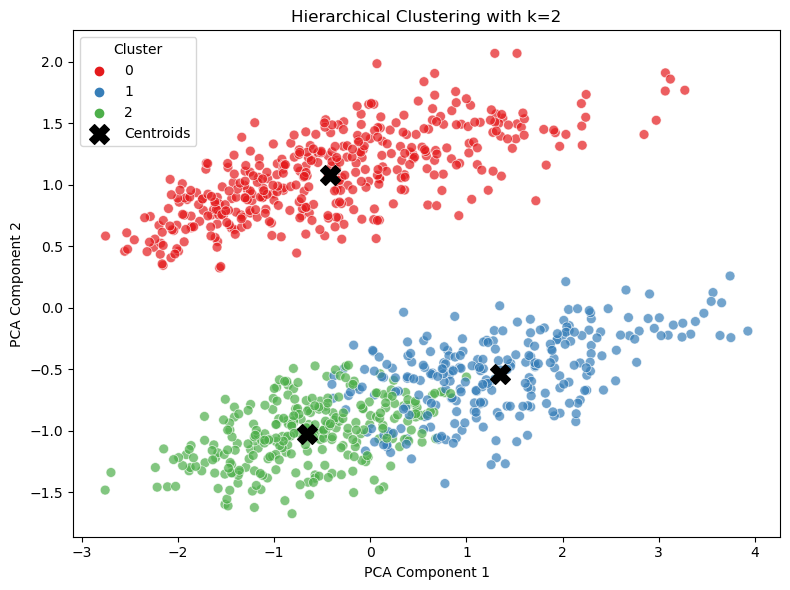

In [37]:

pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_scaled)


X_scaled_df = pd.DataFrame(X_scaled, columns=features)
X_scaled_df['cluster'] = df['hier_cluster'].values


cluster_means = X_scaled_df.groupby('cluster').mean()

centroids_pca = pca.transform(cluster_means.values)


plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=pca_components[:, 0],
    y=pca_components[:, 1],
    hue=df['hier_cluster'],
    palette='Set1',
    s=50,
    alpha=0.7
)


plt.scatter(
    centroids_pca[:, 0],
    centroids_pca[:, 1],
    color='black',
    marker='X',
    s=200,
    label='Centroids'
)

plt.title("Hierarchical Clustering with k=2")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


In [51]:
h_cluster_means = df.groupby('hier_cluster')[feature_columns].mean().round(2)
h_cluster_means


,bpm,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,speechiness_%,liveness_%,mode
hier_cluster,,,,,,,,,
0,121.94,69.33,53.20,65.34,25.17,1.68,11.24,18.19,0.0
1,126.09,57.14,35.59,52.01,39.33,1.96,8.54,16.99,1.0
2,120.11,72.72,63.56,74.11,18.40,1.09,10.03,19.37,1.0


Seemingly well defined clusters, there's over lapping in the PCA, however, that is explained by the existence of subgenres as seen by the dendograph. The 3 clusters show respectable variablity in the centeroid features to distinctively define genres.

### DBSCAN

In [39]:


dbscan = DBSCAN(eps=1.5, min_samples=5)  
df['db_cluster'] = dbscan.fit_predict(X_scaled)


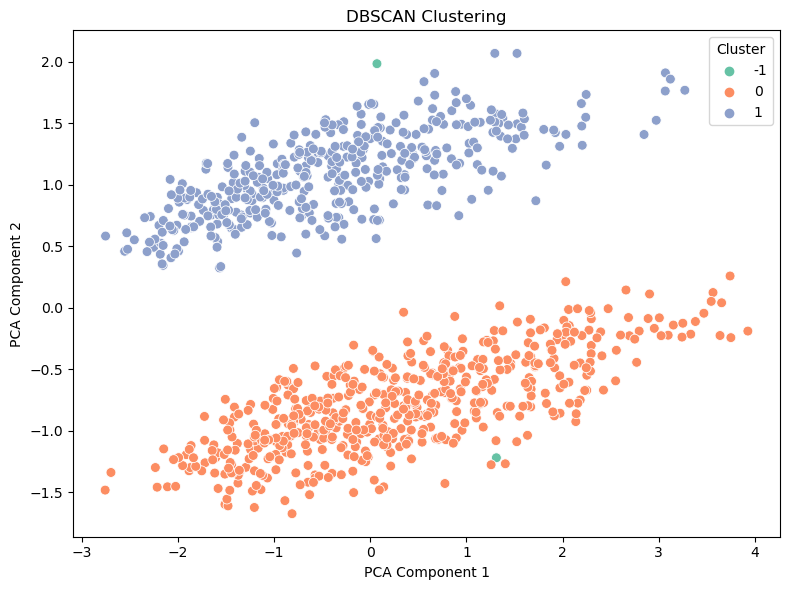

In [40]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=pca_components[:, 0],
    y=pca_components[:, 1],
    hue=df['db_cluster'],
    palette='Set2',
    s=50
)
plt.title("DBSCAN Clustering")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


In [41]:
print("Unique clusters:", df['db_cluster'].nunique())
print("Noise points (-1):", (df['db_cluster'] == -1).sum())


Unique clusters: 3
Noise points (-1): 2


In [42]:
# Check cluster characteristics
df.groupby('db_cluster')[feature_columns].mean()



,bpm,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,speechiness_%,liveness_%,mode
db_cluster,,,,,,,,,
-1,176.000000,57.000000,70.000000,37.000000,72.000000,17.500000,7.000000,11.500000,0.5
0,122.834244,65.313297,50.091075,63.508197,28.355191,1.510018,9.327869,18.240437,1.0
1,121.873134,69.281095,53.169154,65.467662,25.062189,1.599502,11.243781,18.208955,0.0


The features amongst the two genres here show much less specification and variablity than the centeroid features for heirarchal clustering, clusters are still visually better defined than Kmeans.

## Chosen technique for this data: Hierarchal clustering

In [52]:
h_cluster_means

,bpm,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,speechiness_%,liveness_%,mode
hier_cluster,,,,,,,,,
0,121.94,69.33,53.20,65.34,25.17,1.68,11.24,18.19,0.0
1,126.09,57.14,35.59,52.01,39.33,1.96,8.54,16.99,1.0
2,120.11,72.72,63.56,74.11,18.40,1.09,10.03,19.37,1.0


In [56]:
# View sample songs from each cluster
for cluster_id in sorted(df['hier_cluster'].unique()):
    print(f"\nExample songs from Cluster {cluster_id}:")
    display(df[df['hier_cluster'] == cluster_id][['track_name', 'artist(s)_name']].sample(5, random_state=cluster_id))



Example songs from Cluster 0:


,track_name,artist(s)_name
458,Used (feat. Don Toliver),"SZA, Don Toliver"
757,Get Lucky - Radio Edit,"Pharrell Williams, Nile Rodgers, Daft Punk"
133,"Shakira: Bzrp Music Sessions, Vol. 53","Shakira, Bizarrap"
192,Titi Me Preguntï¿,Bad Bunny
145,Stargirl Interlude,"The Weeknd, Lana Del Rey"



Example songs from Cluster 1:


,track_name,artist(s)_name
400,I'm Not The Only One,Sam Smith
81,Until I Found You (with Em Beihold) - Em Beiho...,"Em Beihold, Stephen Sanchez"
588,happier,Olivia Rodrigo
630,Mr. Brightside,The Killers
204,"Phir Aur Kya Chahiye (From ""Zara Hatke Zara Ba...","Arijit Singh, Sachin-Jigar, Amitabha Bhattacharya"



Example songs from Cluster 2:


,track_name,artist(s)_name
18,Classy 101,"Feid, Young Miko"
547,Volvï¿,"Aventura, Bad Bunny"
238,"Link Up (Metro Boomin & Don Toliver, Wizkid fe...","WizKid, Toian, Metro Boomin, Don Toliver, Beam"
644,When Iï¿½ï¿½ï¿½m Gone (with Katy,"Katy Perry, Alesso"
668,California Love - Original Version (Explicit),"Dr. Dre, 2Pac, Roger"


#### Possible Labelings: <br>
**Cluster 0**: "Alt-Pop & Mood Rhythms", features moderately high danceability (69.33%), mid-range energy (65.34%), and a relatively neutral valence (53.20%), indicating a rhythmic yet emotionally complex sound. Its higher speechiness (11.24%) and minor key (mode = 0.0) suggest influences from hip-hop, reggaeton, or alt-R&B, where lyrical delivery and darker tones are prominent. <br>
**Cluster 1**: "Melancholy/Heartfelt & Romantic", shows lower energy (52.01%) and valence (35.59%) alongside higher acousticness (39.33%) and a major key signature (mode = 1.0), reflecting the gentler, emotionally vulnerable quality of ballads, indie tracks, and acoustic love songs. <br>
**Cluster 2**: labeled "Hype & Party Energy", stands out with the highest energy (74.11%), valence (63.56%), and danceability (72.72%), as well as the lowest acousticness (18.40%). This cluster embodies music designed for movement and celebration, aligning with genres like reggaeton, EDM, and classic hip-hop where bold beats and vibrant moods dominate. 
<br>These distinct feature combinations provide clear support for the genre labels assigned to each cluster.



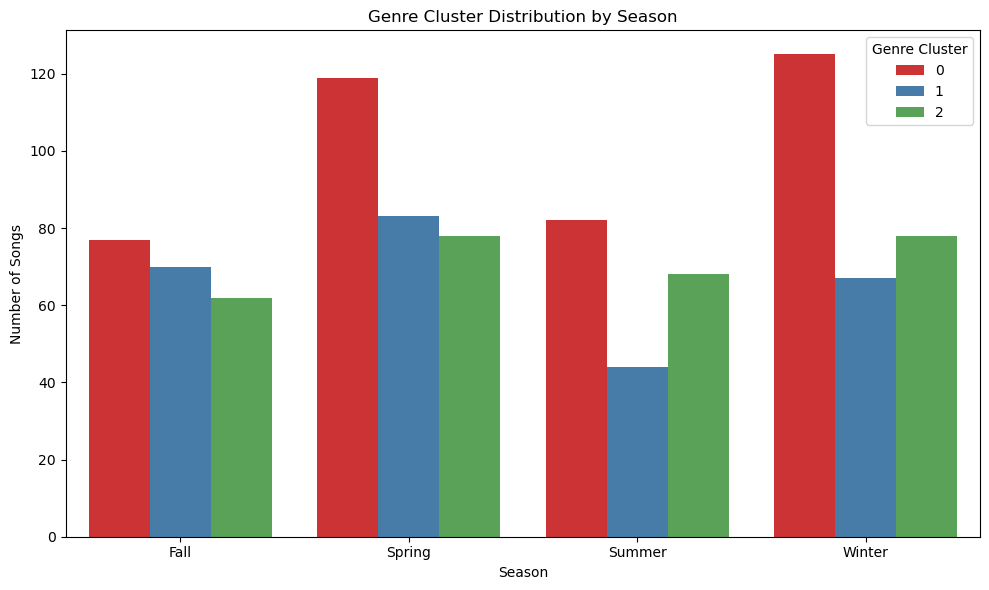

In [45]:

df['season_label'] = df['season'].map(season_labels)


genre_season = df.groupby(['season_label', 'hier_cluster']).size().reset_index(name='count')

plt.figure(figsize=(10, 6))
sns.barplot(data=genre_season, x='season_label', y='count', hue='hier_cluster', palette='Set1')

plt.title('Genre Cluster Distribution by Season')
plt.xlabel('Season')
plt.ylabel('Number of Songs')
plt.legend(title='Genre Cluster')
plt.tight_layout()
plt.show()